<a href="https://colab.research.google.com/github/judahwo/PyTorch_Full_Course/blob/main/02_PyTorch_Classification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8. PyTorch Classification Final: Multi-class Classification Model**

Putting it all together with a multi-class classification problem

Note:<br>
* Binary classification - choice of two (e.g. cat or dog, spam or not spam, fraud or not fraud, etc).
* Multi-class classification = more two (e.g. cat or dog or chicken).

**Resources:** 

**sklearn `make_blobs`:**  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

## **8.1 Multi-class Toy Dataset**

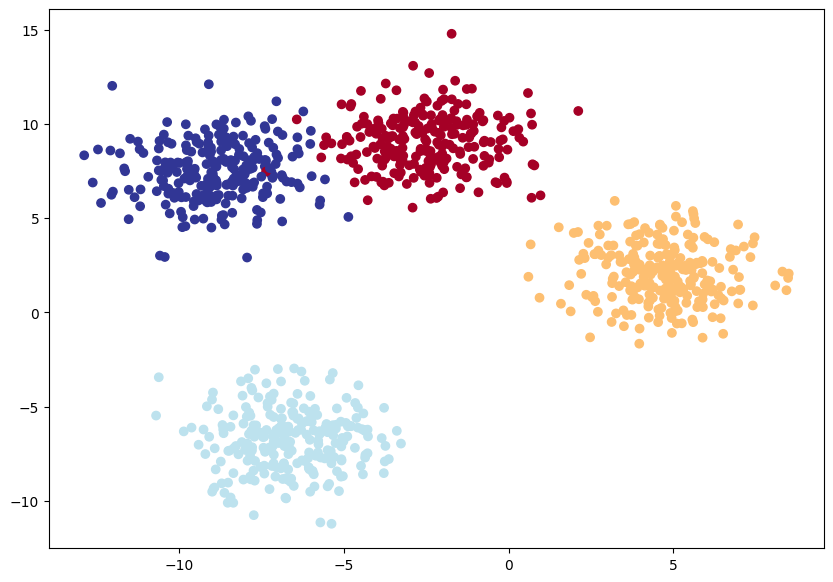

In [ ]:
# Import dependencies
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparamenters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data  
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

## **8.2 Multi_class Model**

**Reference:** 

**Python Docstring Style Guide:** https://google.github.io/styleguide/pyguide.html

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build a multi
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    # Docstring ()
    """Initializes multi-class classification model. 

    Args:
      input_features (int): # of inpute features of the model
      output_features (int): # of output features of the model (in this case classes)
      hidden_unites (int): # of hidden units between layers, default 8

      Returns:

      Example:
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
  def forward (self,x):
    return self.linear_layer_stack(x)

# Create instance of BlobModel and send to target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## **8.3 Multi_class Loss Function and Optimizer**

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

## **8.4 Multi_class Prediction Probabilites**
In order to evaluate, train, and test the model, convert model's outpus to prediction probabilities and then to prediction labels.

Logits (raw outputs) -> Pred Probs (use torch.Softmax) -> Pred Labels (use argmax)

References:

torch.nn.Softmax(): https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.1332,  1.1646, -0.2882,  2.3064],
        [-3.2072, -0.3545, -2.4507, -0.6029],
        [ 1.3340, -0.7274,  2.4218, -3.1867],
        [ 0.3750, -0.4584,  1.2709, -2.1408],
        [-2.6395, -0.3976, -1.8438, -0.9168]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.5423,  1.0608, -0.6391,  2.1779],
        [-3.2900, -1.1803, -2.0057, -2.7452],
        [ 1.3456, -0.3851,  2.2141, -2.2907],
        [ 0.2785,  1.0058,  0.2336,  1.7436],
        [-2.9961,  0.0474, -2.4930,  0.3793]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0453, 0.2252, 0.0412, 0.6883],
        [0.0686, 0.5655, 0.2477, 0.1182],
        [0.2788, 0.0494, 0.6645, 0.0073],
        [0.1197, 0.2477, 0.1145, 0.5181],
        [0.0189, 0.3968, 0.0313, 0.5530]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [ ]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

## **8.5 Multi_class Training and Testing Loop**

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.91936, Acc: 24.62% | Test Loss: 0.82210, Test Acc: 60.50%
Epoch: 10 | Loss: 0.20275, Acc: 97.88% | Test Loss: 0.18590, Test Acc: 99.00%
Epoch: 20 | Loss: 0.10066, Acc: 99.00% | Test Loss: 0.09284, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06999, Acc: 99.00% | Test Loss: 0.06290, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05585, Acc: 99.00% | Test Loss: 0.04857, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04794, Acc: 99.00% | Test Loss: 0.04036, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04297, Acc: 99.00% | Test Loss: 0.03510, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03958, Acc: 99.00% | Test Loss: 0.03148, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03715, Acc: 99.12% | Test Loss: 0.02883, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03533, Acc: 99.12% | Test Loss: 0.02682, Test Acc: 99.50%


## 8.6 Multi_class Making and Evaluating Predictions

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View first 10 preds
y_logits[:10]

tensor([[  7.5506,  12.6036,  -8.8477,  -5.0827],
        [ -1.5831, -15.4809,  -3.4004,   3.9494],
        [-11.9512, -14.8780,  15.9047,   7.5250],
        [  4.0247,   9.6435,  -3.5612,  -3.2161],
        [  7.9236,   3.0020, -13.4122,  -3.2421],
        [ -2.3267, -19.2388,  -3.5514,   4.9872],
        [-10.9329, -10.8614,  15.6550,   6.3360],
        [  5.2367,  -1.8427, -10.4293,  -1.2875],
        [-14.2443, -21.4341,  17.4720,   9.6909],
        [  6.1023,  -0.0464, -11.2951,  -1.9656]], device='cuda:0')

In [ ]:
# Logits -> Pred Probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[6.3495e-03, 9.9365e-01, 4.7978e-10, 2.0710e-08],
        [3.9377e-03, 3.6266e-09, 6.3974e-04, 9.9542e-01],
        [7.9846e-13, 4.2773e-14, 9.9977e-01, 2.2944e-04],
        [3.6159e-03, 9.9638e-01, 1.8353e-06, 2.5917e-06],
        [9.9275e-01, 7.2344e-03, 5.3802e-10, 1.4048e-05],
        [6.6565e-04, 3.0089e-11, 1.9558e-04, 9.9914e-01],
        [2.8378e-12, 3.0480e-12, 9.9991e-01, 8.9698e-05],
        [9.9770e-01, 8.4034e-04, 1.5680e-07, 1.4642e-03],
        [1.6811e-14, 1.2680e-17, 9.9958e-01, 4.1737e-04],
        [9.9756e-01, 2.1311e-03, 2.7756e-08, 3.1268e-04]], device='cuda:0')

In [ ]:
# Pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

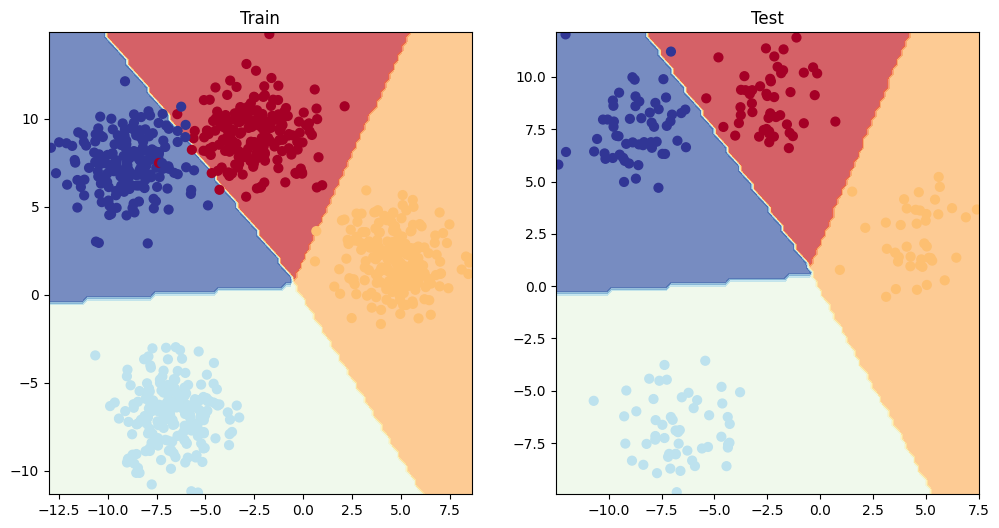

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)